In [1]:
# Using autoregressive flows:

# 1. Maximize the likelihood p(x_1) * p(x_2| x_1) * p(x_3 | x_2, x_1) * ... * p(x_D | x_{D-1}, ..., x_2, x_1) with an autoregressive 
#    flow model with e.g. Gaussian (or Uniform!) marginals
#    This gives a solution z_1, ..., z_D.
# 2. Apply the (known) CDF of z_i (based on the base distribution) to z_i 
#    (with a caveat: checking whether f is monotonically **increasing** or **decreasing** in x_i) 
#    to get the (conditional) cdf of x_i given x_{i-1}, ..., x_1

# Step 1 can probably be implemented with an autoregressive flow, as long as it has infinite approximation capacity
# Step 2 should be easy to apply -- just apply the cdf (for Gaussians, Laplace and Uniform base distributions it is simple; 
# for Laplace and Uniforms it is also quite simple to invert)

# Note also that Step 2 is only useful insofar we want a Uniform distribution, and that however 
# it should in principle be possible for a N.Flow w. ininite approx. capacity to learn the whole Darmois constr.
# if we set the base distribution to be Uniform in step 1.

# This allows us to implement Darmois; but we are actually interested in its inverse.

# Or are we? E.g. for Masked Autoregressive Flows, UAC should be guaranteed (check).
# However, inverting them is not easy.

# However, we might not be interested in this. In fact, what we ultimately care about is the Jacobian of the inverse function.

# But the Jacobian of the inverse function is simply related to that of the direct function.

# This might be sufficient?

In [2]:
# E.g. the CDF of a Gaussian

In [3]:
from jax import numpy as np

### 1. Various CDF functions

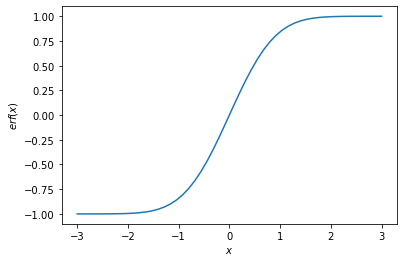

In [4]:
from scipy import special
import matplotlib.pyplot as plt
x = np.linspace(-3, 3)
plt.plot(x, special.erf(x))
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')
plt.show()

In [5]:
# As for an implementation of the inverse CDF of a Gaussian, see below

In [6]:
from scipy import special
y = np.linspace(-1.0, 1.0, num=10)
special.erfinv(y)

array([       -inf, -0.8631231 , -0.54073143, -0.30457014, -0.09879012,
        0.09879015,  0.30457023,  0.54073143,  0.8631231 ,         inf],
      dtype=float32)

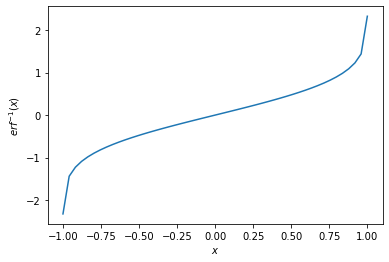

In [7]:
x = np.linspace(-0.999, 0.999)
plt.plot(x, special.erfinv(x))
plt.xlabel('$x$')
plt.ylabel('$erf^{-1}(x)$')
plt.show()

### 2. Autoregressive flows

As a first step, as usual, I will generate the data.

In [8]:
def f_1(x, y):
    "Moderately nonlinear mixing"
    f0 = np.tanh(4*x - 2) + x + y/2
    f1 = np.tanh(4*y - 2) + y + x/2
    return f0, f1

In [9]:
# N:=Number of samples
N = 3000
# D:=Number of dimensions
D = 2

In [10]:
from jax import random
key = random.PRNGKey(0)

S = random.uniform(key, shape=(D, N), minval=0.0, maxval=1.0)

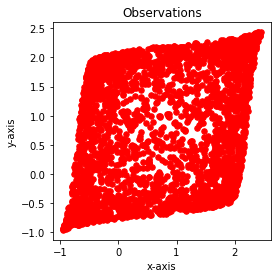

In [11]:
# Apply mixing
X_0, X_1 = f_1(S[0], S[1])

# Plot observations
plt.scatter(X_0, X_1, color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [12]:
X = np.vstack([X_0, X_1]).T
X.shape

(3000, 2)

Now define the autoregressive model we will use to learn the Darmois construction.

In [13]:
# I will use the package developed by Chris Waites and available here:
# https://github.com/ChrisWaites/jax-flows

In [14]:
import sys
sys.path.append('/Users/luigigresele/git/existing_projects/jax-flows')

# To do: change the above before committing to git

In [15]:
import flows

from jax import grad, jit, random
from jax.experimental import stax, optimizers

In [16]:
rng, flow_rng = random.split(random.PRNGKey(0))
input_dim = X.shape[1]
num_epochs, batch_size = 400, 50

Now it's time to construct the normalizing flow model. We'll opt for `MAF` composed of a sequence of 5 blocks.

The core of this library is the concept of a _bijection_. A bijection is characterized by a triplet $(\theta, f_\theta, f^{-1}_\theta)$, where $\theta$ is a parameter vector, and for all $x \in \mathbb{R}^N$, it's the case that $x = f^{-1}_\theta(f_\theta(x))$. Given this characterization, bijections naturally follow a common interface, as described next. 

When you create a bijection, it returns an initialization function `init_fun` which, given a source of randomness `rng` and an `input_dim` tuple returns the aforementioned triplet `(params, direct_fun, inverse_fun)`.

`params` is consistent with the rest of JAX, and is just a tree of numpy matrices containing all of the trainable parameters of the bijection. More importantly, the `direct_fun` and `inverse_fun` are the functions which perform direct and inverse bijections according to params. That is, given `params` and `inputs`, each will return `(outputs, log_det_jacobian)`.

It's worth noting that the composition of several bijections, retrievable by a call to `serial`, is simply a larger, meta-bijection. That is, it adheres to the exact same bijection interface described previously and is indistinguishable from any other bijection.

A _flow_ is such a bijection paired with a prior distribution. A prior distribution should allow one to query the density of a point and sample new points, i.e. it should return `log_pdf` and `sample` functions. Typically a normal distribution is used as the prior, and is used as the implicit default parameter when constructing a flow.

In [17]:
def get_masks(input_dim, hidden_dim=64, num_hidden=1):
    masks = []
    input_degrees = np.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [np.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [np.transpose(np.expand_dims(d1, -1) >= np.expand_dims(d0, 0)).astype(np.float32)]
    return masks

In [18]:
# N.B. In case the base distribution is **uniform**, complement Chris Waites' implementation with the code below
# **CAREFUL**: NOT TESTED YET!

# from jax.scipy.stats import uniform

# def Uniform():
#     """
#     Returns:
#         A function mapping ``(rng, input_dim)`` to a ``(params, log_pdf, sample)`` triplet.
#     """

#     def init_fun(rng, input_dim):
#         min_val = np.zeros(input_dim)
#         max_val = np.ones(input_dim)

#         def log_pdf(params, inputs):
#             return uniform.logpdf(inputs, loc=min_val, scale=max_val)

#         def sample(rng, params, num_samples=1):
#             return random.uniform(rng, shape=input_dim, minval=min_val, maxval=max_val)

#         return (), log_pdf, sample

#     return init_fun

In [19]:
def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=64, num_hidden=1)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(masks[2].tile(2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

In [20]:
init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5),
    flows.Normal()#,
#     Uniform(),
)

In [21]:
# num_examples, input_dim, tol = 20, 3, 1e-4
# layer_rng, input_rng = random.split(random.PRNGKey(0))
# inputs = random.uniform(input_rng, (num_examples, input_dim))
# init_fun = flows.Serial(flows.Shuffle(), flows.Shuffle())
# params, direct_fun, inverse_fun = init_fun(layer_rng, input_dim)
# mapped_inputs = direct_fun(params, inputs)[0]
# reconstructed_inputs = inverse_fun(params, mapped_inputs)[0]
# np.allclose(inputs, reconstructed_inputs).item()

In [22]:
#params, direct_fun, inverse_fun = init_fun(flow_rng, input_dim)

In [23]:
# mapped_inputs = direct_fun(params, inputs)[0]

In [24]:
# mapped_inputs.shape

In [25]:
# init_fun =  flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5)
# params, direct_fun, inverse_fun = init_fun(layer_rng, input_dim)

In [26]:
# mapped_inputs = direct_fun(params, inputs)[0]

In [27]:
# mapped_inputs.shape

In [28]:
params, log_pdf, sample = init_fun(flow_rng, input_dim)

Now, given the model, we can start to optimize it. We can do this by creating a regular JAX Adam optimizer, supplying it the model parameters.

In [29]:
opt_init, opt_update, get_params = optimizers.adam(step_size=5*1e-5)
opt_state = opt_init(params)

In [30]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

Now we'll define the loss we'd like to minimize, as well as the step function which will update our parameters given a batch and compile it.

In [31]:
def loss(params, inputs):
    return -log_pdf(params, inputs).mean()

@jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradients = grad(loss)(params, inputs)
    return opt_update(i, gradients, opt_state)

And now we train!

In [32]:
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from IPython.display import clear_output
import jax.numpy as np

%matplotlib inline

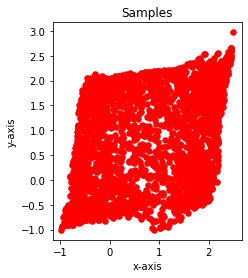

In [33]:
itercount = itertools.count()

for epoch in range(num_epochs):
    clear_output(wait=True) # Clear plotting

    permute_rng, rng = random.split(rng)
    X = random.permutation(permute_rng, X)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
     
    params = get_params(opt_state)
    sample_rng, rng = random.split(rng)
    X_syn = sample(rng, params, X.shape[0])
    
#     plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=n_bins, range=plot_range)
#     plt.show()
    plt.scatter(X_syn[:,0], X_syn[:,1], color='r', s=30)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.title('Samples')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

params = get_params(opt_state)

In [34]:
loss(params, X)

DeviceArray(1.985513, dtype=float32)

In [35]:
# Forward function
init_forward_pass =  flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5)
_, direct_fun, inverse_fun = init_forward_pass(flow_rng, input_dim)

In [36]:
Y = direct_fun(params, X)[0]

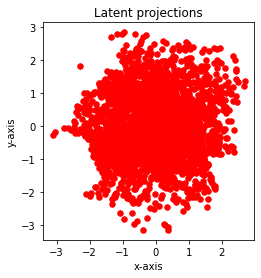

In [37]:
plt.scatter(Y[:,0], Y[:,1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [38]:
import jax

In [39]:
Y_ = jax.scipy.stats.norm.cdf(Y)

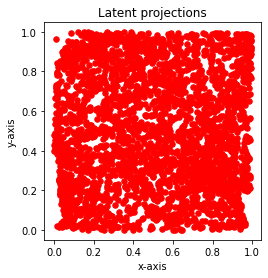

In [40]:
plt.scatter(Y_[:,0], Y_[:,1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Is this the Darmois construction?

Also, compare it with the true solution based on, e.g., FastICA?

In [41]:
X_hat = inverse_fun(params, Y)[0]

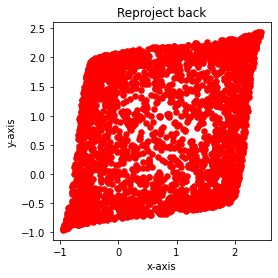

In [42]:
plt.scatter(X_hat[:,0], X_hat[:,1], color='r', s=30)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reproject back')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Notes on what is missing:

- ~~The code above gives you the forward function + log-pdf; it would be nice to be able to return the output of the forward function **alone**.~~
- ~~Moreover, it should be composed with the CDF of the base distribution to replicate the Darmois construction~~
- The composition with the CDF should be s.t. it is based on the sign of the derivative!
- **Where is the Jacobian returned (if anywhere?)** Should we compute it with autodiff for simplicity? Note that this should somehow be computed in `flow.Flow()`

Also replicate the plot by Aapo!

In [43]:
S = S.T

In [44]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [45]:
rho, phi = cart2pol( S[:, 0]-0.5, S[:,1]-0.5)

In [46]:
np.max(phi)

DeviceArray(3.1408236, dtype=float32)

In [47]:
# theta = np.divide(S[:,1]-0.5, S[:, 0]-0.5)
colors = phi

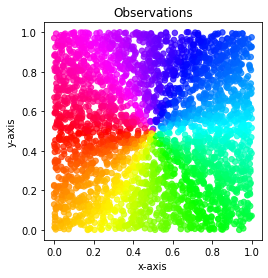

In [48]:
# Apply mixing

# Plot observations
plt.scatter(S[:,0], S[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

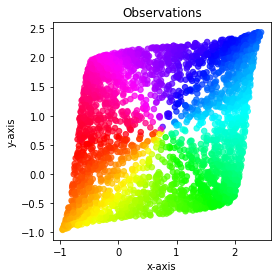

In [49]:
# Apply mixing
X_0, X_1 = f_1(S[:, 0], S[:, 1])

# Plot observations
plt.scatter(X_0, X_1, c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Observations')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [50]:
X = np.vstack([X_0, X_1]).T
X.shape

(3000, 2)

In [51]:
Y = direct_fun(params, X)[0]

In [52]:
Y_ = jax.scipy.stats.norm.cdf(Y)

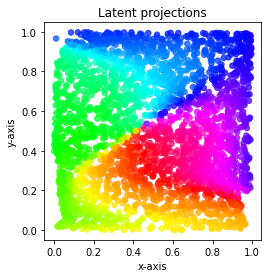

In [53]:
plt.scatter(Y_[:,0], Y_[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [54]:
X_hat = inverse_fun(params, Y)[0]

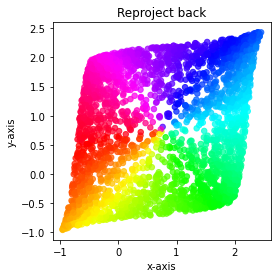

In [55]:
plt.scatter(X_hat[:,0], X_hat[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reproject back')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# I need to check whether the Darmois construction learned with the Flow is similar (equal?) to the one with my shitty costum function

Problem: Jax arrays do not support item assignment! Therefore my function is not compatible
Solution: Create the array using `numpy` (not `jax.numpy`) imported as `onp`.

In [56]:
import numpy as onp

In [57]:
# Code below exactly copied from the 1st notebook!

In [58]:
from statsmodels.distributions.empirical_distribution import ECDF

In [59]:
def g_1(x):
    '''
    Takes a collection of N samples as input and returns their cdf transform
    
    Input:
    x = N dimensional array
    
    Output:
    N dimensional array
    '''
    ecdf = ECDF(x)
    return ecdf(x)

In [60]:
def g_darmois(X_0, X_1, bins_y=100):
    '''
    Takes two collections of N univariate samples (that is, N bivariate samples) as input and outputs the Darmois construction.
    Requires binning over the y_0=g_1(X_0, X_1) values in order to compute the **conditional** CDF
    
    Input:
    X_0 =  N dimensional array
    X_1 =  N dimensional array
    bins_y = n bins to discretize y_1
    
    Output:
    N dimensional array, N dimensional array
    '''    
    
    # Compute the 1st component of the estimated sources
    y_0 = g_1(X_0)

    # Create a 2d array with y_0 and X_1
    # The **third** row --- that is, arr[2,:] --- will be populated with the 2nd component of the estimated sources
    arr = onp.vstack([y_0, X_1, y_0])
        
    # Establish binning for y_1
    upper_limit = onp.max(y_0)
    lower_limit = onp.min(y_0)
    binning = np.linspace(lower_limit, upper_limit, num=bins_y)    
    
    # Return cdf
    for i in range(bins_y-1):
        cond1 = arr[0,:]>=binning[i]
        cond2 = arr[0,:]<binning[i+1]
        and_cond = onp.logical_and(cond1, cond2)
        ecdf = ECDF(arr[1, and_cond])
        arr[2, and_cond] = ecdf(arr[1, and_cond]) # select only the proper bins!

    return y_0, arr[2,:]

In [61]:
Y_0_darm, Y_1_darm = g_darmois(X_0, X_1, bins_y=70)

In [62]:
import cmocean

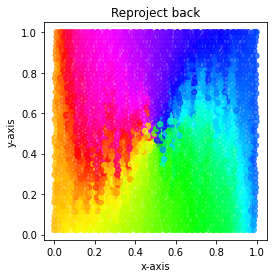

In [63]:
plt.scatter(Y_0_darm, Y_1_darm, c=colors, s=30, alpha=0.75, cmap='hsv')#cmap=cmocean.cm.phase)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Reproject back')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [64]:
Y_1_darm.shape

(3000,)

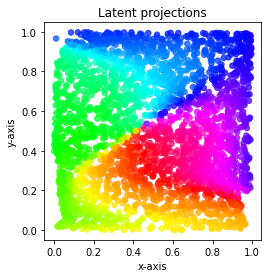

In [65]:
plt.scatter(Y_[:,0], Y_[:,1], c=colors, s=30, alpha=0.75, cmap='hsv')#cmap=cmocean.cm.phase)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Latent projections')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [66]:
Y_[:,0].shape

(3000,)